# Lab 6 Generative models

This notebook has been prepared by Hsiu-Wen Chang from MINES ParisTech
Shall you have any problem, send me [email](hsiu-wen.chang_joly@mines-paristech.fr)

In this practical lesson, we will use Pytorch to learn autoencoder in order to understand the limitations of it. Then the second part introduces variational autoencoder to show how we can genrate new synthetic images from some unknown (but learnable from givien images) distribution P 

## Part 1: Autoencoder

Encoder is a process that produces `new features` representation from the `old features`, either by selection or extraction, and decoder the reverse process. When the dimension of the new features (n_d) is relative low compare to the dimension of the old feature (n_e), we call this Dimensionality reduction. This is a popular processfor for data compression such as video, audio, etc. The main purpose of dimensionality reduction is to find the best encoder/decoder pair among a give family. 

Hereafter, we denote E and D as the families of encoders and decoder, respectively. We define the reconstruction error measures between the input data $x$ and the encoder data $d(e(x))$ as $\epsilon(x,d(e(x))$. Then we can formulate this problem as:

$$(e^*,d^*) = \underset{(e,d)\in ExD}{\operatorname{argmax}}{\epsilon(x, d(e(x)))}$$

The general idea of autoencoders is simple that we try to learn the best encorder $e^*$ and decoder $d^*$ as neural networks using an iterative optimisation processs.

In [ ]:
# If you want to run these code locally, copy these installation into requirements.txt
# You might not use pytorch-lightning if you have installation issues. 
# Pytorch-lightning will accelearte the training it can access to GPU or TPU. 
# Therefore, it is not neccessary in this tutorial
# !pip install pytorch-lightning==1.0.8
# !pip install pytorch-lightning-bolts

In [4]:
# Fundamental packages
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import copy
import torch.nn as nn
import torch.nn.functional as F
import os

Now let's try to do this on MINST images of digits. Note that the size of the image is 28x28 pixels. To accelerate the training process, we can use transformation functions in torchvision. Here we will apply normalization

In [5]:
batch_size_train = 10
batch_size_test = 100

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Now we should check the data before we define our model

Loaded image shape in tensor: torch.Size([10, 1, 28, 28])


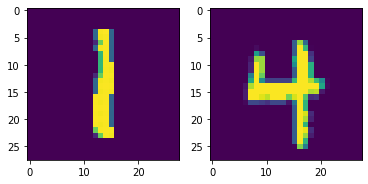

In [6]:
# get minibatch
x,target = next(iter(train_loader)); x_test,_ = next(iter(test_loader))
print('Loaded image shape in tensor:', x.size())
fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][1]);
axes[0].imshow(x[0][0].numpy()); axes[1].imshow(x_test[0][0].detach().numpy());

In [31]:
input_size = 784

# Hyperparameters
encoding_dim = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 10
n_epochs = 3

Now let's create a simple encoder that consists one linear layer with ReLU activation as well as one decoder that consists one linear layer. Then we create an autoencoder that consists the encoder and decoder we just defined. Pay attention that we will use sigmoid function to make sure the reconstructed pixels are within normalized range. 

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(input_size, encoding_dim), 
             nn.ReLU()])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(encoding_dim, input_size)])
    
    def forward(self,z):
        for layer in self.layers:
            z = layer(z)
        return z

class Autoencoder(nn.Module):
    def __init__(self, input_size = 784, encoding_dim = 32):
        super().__init__()
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten to (nm, 1) vector
        x = self.encoder(x) # here we get the latent z
        x = self.decoder(x) # here we get the reconsturcted input
        x = torch.sigmoid(x)
        x = x.reshape(x.size(0), 1,28,28) # reshape this flatten vector to the original image size    
        return x
    
        

In [8]:
autoencoder = Autoencoder(784,32)

Here is what the initial autoencoder generates.

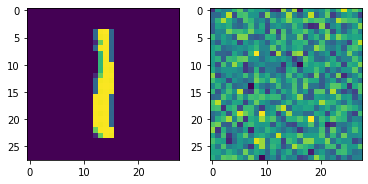

In [9]:
fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][1]);
axes[0].imshow(x[0][0].numpy()); axes[1].imshow(autoencoder(x)[0][0].detach().numpy());

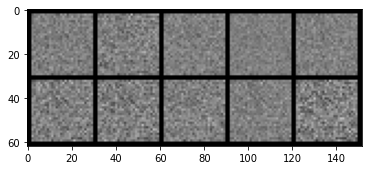

In [23]:
# Here we can also use make_grid function to plot images
# In Pytorch, the shape of images are (B,C,H,W) 
# make_grid return arrays in (C, Hs, Ws)
# In matplotlib, we need (H,W,C)
from torchvision.utils import make_grid
with torch.no_grad():
    reconstruct_ims = autoencoder(x).cpu()

ims = make_grid(reconstruct_ims, nrow=5).permute(1,2,0).numpy()
plt.imshow(ims)

Now we move to define how our autoencoder should be trainned. In this function of `train` we directly include the test data process at the end of training. 

In [24]:
def train(model, trainloader = None, valloader = None, num_epochs = 1):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # name dataloaders for phrase
    phases = ['train']
    dataloaders = {'train':trainloader}
    if valloader:
        phases.append('valid')
        dataloaders['valid'] = valloader
        
    model.to(device)
    optimizer = torch.optim.Adadelta(autoencoder.parameters())
    #criterion = F.binary_cross_entropy(autoencoder(x), target)
    criterion = torch.nn.BCELoss()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss, running_correct, count = 0.0, 0, 0
            for batch_idx, (x, y) in enumerate(dataloaders[phase]):
                x,y = x.to(device), y.to(device)

                # zero param gradients
                optimizer.zero_grad()

                # forward: track history if training phase
                with torch.set_grad_enabled(phase=='train'): # pytorch >= 0.4
                    outputs = model(x)
                    loss    = criterion(outputs, x)
                    preds,_ = torch.max(outputs,1) # for accuracy metric
                    # backward & optimize if training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # stats
                running_loss += loss.item() * x.size(0)
                count += len(x)
            
            epoch_loss = running_loss / count
            print(f'{phase} loss {epoch_loss:.6f}')
        print()
            

In [25]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=1)

Epoch 1/1
----------
train loss -39.517523
valid loss -45.539233

CPU times: user 46.9 s, sys: 8.2 s, total: 55.1 s
Wall time: 1min 19s


Now we can plot the result of autoencoder to see how closs these two images are

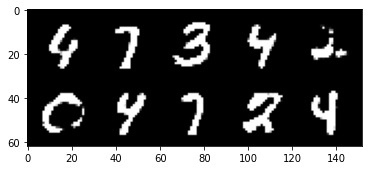

In [29]:
x,y = next(iter(train_loader))
#z = autoencoder(x)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
with torch.no_grad():
    reconstruct_ims = autoencoder(x).cpu()
ims = make_grid(reconstruct_ims, nrow=5).permute(1,2,0).numpy()
plt.imshow(ims)

## Limitation of autoencoder
In the above example, our encoder and decoder architectures have only one layer without non-linearity. Such encoder-deocoder represent linear transformations (the sigmoid function can be removed since it is simply the function to accelerate the training). It is worth mentioning that Principle Componet Anaysis (PCA) defines one of the soltuions (basis) that satisfied the minimum of reconstruction error. For our autoencoder, indeed, can have several basis that describe the same optimal subspace. It ends up that the new features do not have to be independent.

With deeper and more complex architectures, the more the autoencoder can processed to high dimensionality reduction while keeping reconstruction loss low. It invokes an impoartant issue in traditional autoencoder: **the lack of interpretable and exploitable structures in the latent space**. Beside, once the autoencoder has been trained, we still have no way to produce any new content based on the trained latent space. 

Key to solve this issue: get the distribution of latent space so we can generate samples from this space ==> Variational Autoencoders (VAE)
![](AE_VAE.png)

### Task 1:
Change your encoder and decoder to use 2D convolutional layers. Train it and see the difference.

## Part 2: Variational Autoencoder

*Credits goes to William Falcon from NYU who created this nice [code](https://github.com/williamFalcon/pytorch-lightning-vae)